# Simulation Model for the Spherical Coordinate System

## 1) Initialization

In [76]:
#from conora.backend import GEKKO
from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7,7)

## 2) Setup Problem

### 2.1) Constants

In [77]:
# CONSTANTS
M = 7.34767E22      # mass of the Moon [kg]
G = 6.67408E-11     # gravitational constant [m^3 kg^-1 s^-2]
Rm = 1737.1E3       # Radius of the Moon [m]
w = 2.66170E-6      # rotational speed of the Moon [rad s^-1]
Isp = 457           # specific impulse [kg N^-1 s^-1]
th_m = 50*1E4/Isp   # maximum thrust
g0 = 9.81           # Earth gravitational constant [m s^-2]
orb = 560000        # altitude of the orbit [m]
orb2 = 310000
tol = 10000         # tolerance of the orbit values [m]

### 2.2) Gekko Implementation

In [78]:
# CREATION OF THE GEKKO MODEL
mS = GEKKO()

# SET GLOBAL OPTIONS
mS.options.IMODE = 6     # orthogonal collocation optimization

# TIME VECTOR
nt = 900
step = 30
mS.time = np.linspace(0,nt,step)
tS = mS.Param(value=mS.time)

# STATE VARIABLES
x1S = mS.SV(value=0)                               # r-component of the velocity vector - as a rough approximation, the max speed is initially set at 10000m/s
x2S = mS.SV(value=w)                               # theta-component of the velocity vector
x3S = mS.SV(value=0)                               # phi-component of the velocity vector
x4S = mS.SV(value=Rm, lb=Rm)                       # r-component of the position vector (surface of the Moon)
x5S = mS.SV(value=0, lb=-np.pi, ub=np.pi)          # theta-longitude
x6S = mS.SV(value=0, lb=-np.pi/2, ub=np.pi/2)      # phi-latitude
x7S = mS.SV(value=20000, lb=0, ub=20000)           # mass of the system [kg]


# INTERMEDIATE VARIABLES
altS = mS.Intermediate(x4S-Rm)                     # altitude of the LM [kg]


# INPUT VARIABLES    
#u1S_val = [(-3*1E4/Isp/nt*t+3.3*1E4/Isp) for t in mS.time]
#u1S_val = [( ((-2*1E4/Isp/nt*t+1E4/Isp)**2+(1.5*1E4/Isp/nt*t)**2)**(1/2) if t<nt/2 else ((-2*1E4/Isp/nt*t+1E4/Isp)**2+(-1.5*1E4/Isp/nt*t+1.5*1E4/Isp)**2)**(1/2)  ) for t in mS.time]
#u1S_val = [ (20+0.002*(20*t) if t<nt/2 else ) for t in mS.time]
u1S_val = [ (15+0.00000001*t if t<nt/1.3 else 20+0.00000001*t) for t in mS.time]
u1S = mS.MV(value=15.0001, lb=0, ub=th_m)                                  # magnitude of the thrust vector - as a rough approximation, the max mass flow is initially set at 0.5*max_mass/Isp      

u2S_val = [((np.pi/2.2)-7*0.0001*t-2.79*0.000001*t**2) for t in mS.time]
u2S = mS.MV(value=u2S_val, lb=-np.pi, ub=np.pi)                            # alpha-pitch angle of the thrust

u3S = mS.MV(value=0, lb=-np.pi/2, ub=np.pi/2)                              # beta-yaw angle of the thrust
#u3.STATUS = 1


# CONSTANT PARAMETERS
p1S = mS.Const(value=Isp*g0)      # Isp*g0
p2S = mS.Const(value=G*M)         # G*M

# EQUATIONS OF MOVEMENT
mS.Equation(x1S.dt() == -(p2S)/(x4S**2) + (p1S*u1S*mS.sin(u2S))/(x7S) + x4S*(x2S**2)*((mS.cos(x6S))**2) + x4S*(x3S**2) )
mS.Equation(x2S.dt() == ( ((p1S*u1S*mS.cos(u2S)*mS.cos(u3S))/(x7S)) - (2*x1S*x2S*mS.cos(x6S)) + (2*x4S*x2S*x3S*mS.sin(x6S)) )/(x4S*mS.cos(x5S)) )
mS.Equation(x3S.dt() == ( ((p1S*u1S*mS.cos(u2S)*mS.sin(u3S))/(x7S)) - (2*x1S*x3S) - (x4S*(x3S**2)*mS.sin(x6S)*mS.cos(x6S)) )/(x4S) )
mS.Equation(x4S.dt() == x1S )
mS.Equation(x5S.dt() == x2S )
mS.Equation(x6S.dt() == x3S )
mS.Equation(x7S.dt() == -u1S )

#mS.Equation(x1S.dt() == u1S*mS.sin(u2S)/x7S-p2S/x4S**2+(x2S**2+x3S**2)/x4S -2*w*x3S*mS.cos(x6S)*mS.cos(gammaS)+2*w*x2S*mS.cos(x6S)*mS.sin(gammaS)+w**2*x4S*mS.cos(x6S)**2)
#mS.Equation(x2S.dt() == u1S*mS.cos(u2S)*mS.cos(u3S)/x7S-x1S*x2S/x4S+x2S*x3S*mS.sin(gammaS)*mS.tan(x6S)/x4S-x3S**2*mS.cos(gammaS)*mS.tan(x6S)/x4S -2*w*x1S*mS.cos(x6S)*mS.sin(gammaS)+2*w*x3S*mS.sin(x6S)-w**2*x4S*mS.sin(x6S)*mS.cos(x6S)*mS.cos(gammaS))
#mS.Equation(x3S.dt() == u1S*mS.cos(u2S)*mS.sin(u3S)/x7S-x1S*x3S/x4S+x2S*x3S*mS.cos(gammaS)*mS.tan(x6S)/x4S-x2S**2*mS.sin(gammaS)*mS.tan(x6S)/x4S +2*w*x1S*mS.cos(x6S)*mS.cos(gammaS)-2*w*x2S*mS.sin(x6S)-w**2*x4S*mS.sin(x6S)*mS.cos(x6S)*mS.sin(gammaS))
#mS.Equation(x4S.dt() == x1S )
#mS.Equation(x5S.dt() == (x2S*mS.sin(gammaS)-x3S*mS.cos(gammaS))/(x4S*mS.cos(x6S)) )
#mS.Equation(x6S.dt() == (x2S*mS.cos(gammaS)+x3S*mS.sin(gammaS))/x4S )
#mS.Equation(x7S.dt() == -u1S/p1S )
#mS.Equation(x4S >= Rm)

# CONSTRAINTS
# Initial conditions
mS.fix_initial(x1S, val=0)
mS.fix_initial(x2S, val=w)
mS.fix_initial(x3S, val=0)
mS.fix_initial(x4S, val=Rm)
mS.fix_initial(x5S, val=0)
mS.fix_initial(x6S, val=0)
mS.fix_initial(x7S, val=20000)
#mS.fix_initial(u1S, val=u1S_val)

# OBJECTIVE FUNCTION
p = np.zeros(step)     # mark final time point
p[-1] = 1.0
final = mS.Param(value=p)

mS.Obj(-x7S*final)      # maximization of the final mass


## 3) Simulation

In [79]:
 # SOLVE THE PROBLEM
#mS.solve(disp=True, debug=0)
mS.solve(debug=0)

apm 95.33.231.218_gk_model17 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 0.9.2
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            2
   Variables    :           12
   Intermediates:            1
   Connections  :           14
   Equations    :            9
   Residuals    :            8
 
 Number of state variables:            754
 Number of total equations: -          754
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :              0
 
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipo

## 4) Graphics & Post-Processing


Results
x1S: -56.312150438
x2S: 0.0012847913304
x3S: 0.0
x4S: 2296754.1786
x5S: 0.50465815367
x6S: 0.0
x7S: 6499.91
Final Altitude: 559654.17861


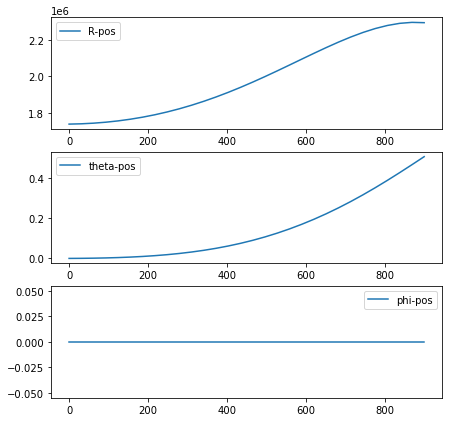

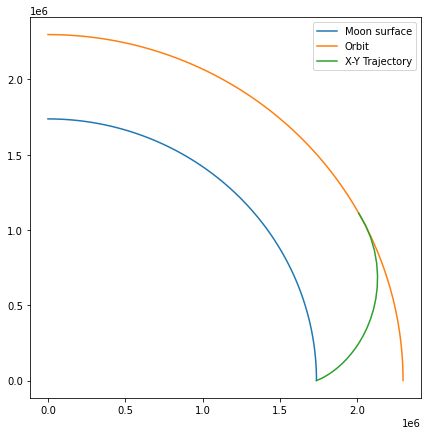

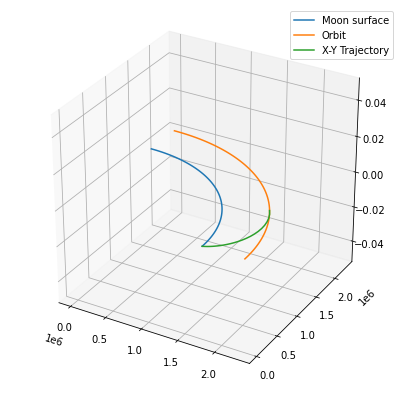

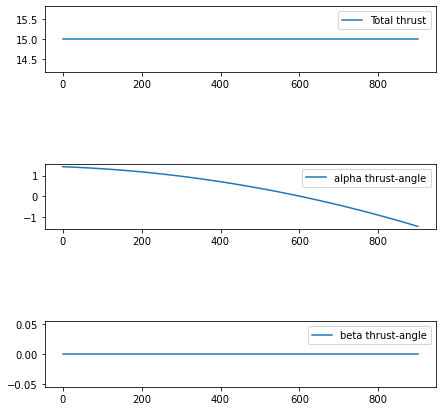

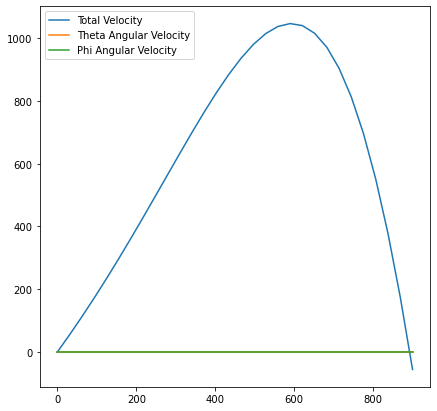

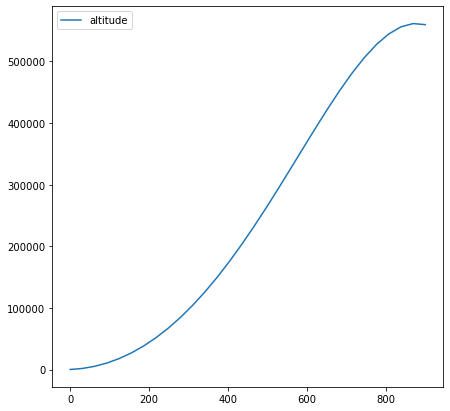

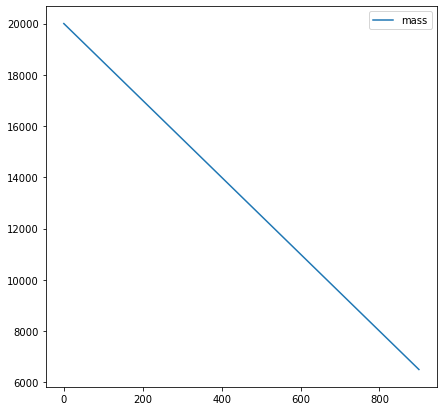

In [80]:
# PLANET AND ORBIT PARAMETRIZATION
theta = np.linspace(0, np.pi/2, 100)
x1_M = Rm*np.cos(theta)                   # moon parametrization
x2_M = Rm*np.sin(theta)
x1_O = (Rm+orb)*np.cos(theta)             # orbit parametrization
x2_O = (Rm+orb)*np.sin(theta)
x1_O2 = (Rm+orb2)*np.cos(theta)             # orbit 1 parametrization
x2_O2 = (Rm+orb2)*np.sin(theta)

# PLOT
print('')
print('Results')
print('x1S: ' + str(x1S.value[-1]))
print('x2S: ' + str(x2S.value[-1]))
print('x3S: ' + str(x3S.value[-1]))
print('x4S: ' + str(x4S.value[-1]))
print('x5S: ' + str(x5S.value[-1]))
print('x6S: ' + str(x6S.value[-1]))
print('x7S: ' + str(x7S.value[-1]))
print('Final Altitude: ' + str(altS.value[-1]))

#i=0
#n=11
#x1S_post = [0] * n
#x2S_post = [0] * n
#x3S_post = [0] * n
#x4S_post = [0] * n
#x5S_post = [0] * n
#x6S_post = [0] * n
#x7S_post = [0] * n
#u1S_post = [0] * n
#u2S_post = [0] * n
#u3S_post = [0] * n
#altS_post = [0] * n
#tS_post = [0] * n

#while i<n:
    #x1S_post[i]=x1S.value[i]
    #x2S_post[i]=x2S.value[i]
    #x3S_post[i]=x3S.value[i]
    #x4S_post[i]=x4S.value[i]
    #x5S_post[i]=x5S.value[i]
    #x6S_post[i]=x6S.value[i]
    #x7S_post[i]=x7S.value[i]
    #u1S_post[1]=u1S.value[i]
    #u2S_post[1]=u2S.value[i]
    #u3S_post[1]=u3S.value[i]
    #altS_post [i] = altS.value[i]
    #tS_post [i] = tS.value[i]
    #i=i+1
    
# Position
plt.figure()
plt.subplot(311)
#plt.plot(tS_post,x4S_post,label='R-pos')
plt.plot(tS,x4S.value,label='R-pos')
plt.legend(loc='best')
plt.subplot(312)
#plt.plot(tS_post,x5S_post,label='theta-pos')
plt.plot(tS,x5S.value,label='theta-pos')
plt.legend(loc='best')
plt.subplot(313)
#plt.plot(tS_post,(x6S_post),label='phi-pos')
plt.plot(tS,(x6S.value),label='phi-pos')
plt.legend(loc='best')

# Trajectory
plt.figure()
plt.plot(x1_M,x2_M,label='Moon surface')
plt.plot(x1_O,x2_O,label='Orbit')
#plt.plot(x4S_post*np.cos(x5S_post),x4S_post*np.sin(x5S_post),label='X-Y Trajectory')
plt.plot(x4S.value*np.cos(x5S.value),x4S.value*np.sin(x5S.value),label='X-Y Trajectory')
plt.legend(loc='best')

# # Trajectory 3D
fig3D = plt.figure()
ax = fig3D.add_subplot(111, projection='3d')
plt.plot(x1_M,x2_M,label='Moon surface')
plt.plot(x1_O,x2_O,label='Orbit')
#plt.plot(x4S_post*np.cos(x5S_post),x4S_post*np.sin(x5S_post),label='X-Y Trajectory')
plt.plot(x4S.value*np.cos(x5S.value),x4S.value*np.sin(x5S.value),label='X-Y Trajectory')
plt.legend(loc='best')

# Thrust
plt.figure()
plt.subplot(511)
#plt.plot(tS_post,u1S_post,label='Total thrust')
plt.plot(tS,u1S.value,label='Total thrust')
plt.legend(loc='best')
#plt.subplot(512)
#plt.plot(tS,u1S_val,label='Changing thrust')
#plt.legend(loc='best')
plt.subplot(513)
#plt.plot(tS_post,u2S_post,label='alpha thrust-angle')
plt.plot(tS,u2S.value,label='alpha thrust-angle')
plt.legend(loc='best')
#plt.subplot(514)
#plt.plot(tS,u2S_val,label='Changing alpha')
#plt.legend(loc='best')
plt.subplot(515)
#plt.plot(tS_post,u3S_post,label='beta thrust-angle')
plt.plot(tS,u3S.value,label='beta thrust-angle')
plt.legend(loc='best')

# Speed (individual components)
plt.figure()
#plt.plot(tS_post,x1S_post,label='Total Velocity')
plt.plot(tS,x1S.value,label='Total Velocity')
#plt.plot(tS_post,x2S_post,label='Theta angular velocity')
plt.plot(tS,x2S.value,label='Theta Angular Velocity')
#plt.plot(tS_post,x3S_post,label='Phi angular velocity')
plt.plot(tS,x3S.value,label='Phi Angular Velocity')
plt.legend(loc='best')

# Altitude
plt.figure()
#plt.plot(tS_post,altS_post,label='altitude')
plt.plot(tS.value,altS.value,label='altitude')
plt.legend(loc='best')

# Flight path angle
#plt.figure()
#plt.plot(tS,gammaS,label='FPA')
#plt.legend(loc='best')

# Speed
#plt.figure()
#plt.plot(tS,speedS,label='speed')
#plt.legend(loc='best')

# Mass
plt.figure()
#plt.plot(tS_post,x7S_post,label='mass')
plt.plot(tS.value,x7S.value,label='mass')
plt.legend(loc='best')

# Optimization Model for the Spherical Coordinate System

## Gekko Implementation

In [137]:
# CREATION OF THE GEKKO MODEL
mO = GEKKO()

# SET GLOBAL OPTIONS
mO.options.IMODE = 6          # orthogonal collocation optimization
mO.options.NODES = 30
mO.options.MAX_ITER = 500
mO.options.CSV_WRITE = 2      # write results_all.json with internal nodes

# TIME VECTOR
nt = 900
step = 30
mO.time = np.linspace(0,nt,step)
tO = mO.Param(value=mO.time)

# FINAL TIME POINT
p = np.zeros(step)          # mark final time point
p[-1] = 1.0
final = mO.Param(value=p)


# STATE VARIABLES
x1O_val = x1S
x1O = mO.SV(value=x1O_val)                                # x-component of the velocity vector
#x1O = mO.SV(value=x1O_val, lb=-2000, ub=2000)             # x-component of the velocity vector

x2O_val = x2S
x2O = mO.SV(value=x2O_val)                                # y-component of the velocity vector
#x2O = mO.SV(value=x2O_val, lb=-np.pi/3, ub=np.pi/3)       # y-component of the velocity vector

x3O_val = x3S
x3O = mO.SV(value=x3O_val)                                # z-component of the velocity vector

x4O_val = x4S
x4O = mO.SV(value=x4O_val, lb=Rm)                         # x-component of the position vector (surface of the Moon)
#x4O = mO.SV(value=x4O_val, lb=Rm, ub=(Rm+orb) )          # x-component of the position vector (surface of the Moon)

x5O_val = x5S
x5O = mO.SV(value=x5O_val, lb=-np.pi, ub=np.pi )          # y-component of the position vector

x6O_val = x6S
#x6O = mO.SV(value=x6O_val)                               # z-component of the position vector
x6O = mO.SV(value=x6O_val, lb=0, ub=np.pi/2)              # z-component of the position vector 0.00000000000001

x7O = mO.SV(value=20000, lb=0, ub=20000)                  # mass of the system [kg]


# INTERMEDIATE VARIABLES
alt_val = x4O-Rm
altO = mO.Intermediate(alt_val)                           # altitude of the LM [kg]


# INPUT VARIABLES    
#u1O_val = [ (15+0.00000001*t if t<nt/1.3 else 20+0.00000001*t) for t in mS.time]
u1O_val = [ (15.000001) for t in mS.time]
u1O = mO.MV(value=u1O_val, lb=0, ub=th_m)                                         # magnitude of the thrust vector - as a rough approximation, the max mass flow is initially set at 0.5*max_mass/Isp      
u1O.STATUS = 1

u2O_val = [((np.pi/2.2)-7*0.0001*t-2.79*0.000001*t**2) for t in mS.time]
u2O = mO.MV(value=u2O_val, lb=-np.pi, ub=np.pi)                                   # alpha-pitch angle of the thrust
#u2O.STATUS = 1

#u3O = mS.MV(value=0, lb=-np.pi/2, ub=np.pi/2)                                     # beta-yaw angle of the thrust
u3O = mO.MV(0)
#u3O.STATUS = 1


# CONSTANT PARAMETERS
p1O = mO.Const(value=Isp*g0)      # Isp*g0
p2O = mO.Const(value=G*M)         # G*M
tol = mO.Const(value = 5000)      # tolerance on the distance

# EQUATIONS OF MOVEMENT
mO.Equation(x1O.dt() == -(p2O)/(x4O**2) + (p1O*u1O*mO.sin(u2O))/(x7O) + x4O*(x2O**2)*((mO.cos(x6O))**2) + x4O*(x3O**2) )
mO.Equation(x2O.dt() == ( ((p1O*u1O*mO.cos(u2O)*mO.cos(u3O))/(x7O)) - (2*x1O*x2O*mO.cos(x6O)) + (2*x4O*x2O*x3O*mO.sin(x6O)) )/(x4O*mO.cos(x5O)) )
mO.Equation(x3O.dt() == ( ((p1O*u1O*mO.cos(u2O)*mO.sin(u3O))/(x7O)) - (2*x1O*x3O) - (x4O*(x3O**2)*mO.sin(x6O)*mO.cos(x6O)) )/(x4O) )
mO.Equation(x4O.dt() == x1O )
mO.Equation(x5O.dt() == x2O )
mO.Equation(x6O.dt() == x3O )
mO.Equation(x7O.dt() == -u1O)

#mO.Equation(x4S.value[-1]-tol <= x4O*final <= x4S.value[-1]+tol)     # constraint on final position - x-dir
#mO.Equation(x4S.value[-1]-tol <= x4O*final <= x4S.value[-1]+tol)     # constraint on final position - y-dir

#mO.Equation(x1O.dt() == u1O*mO.sin(u2O)/x7O-p2O/x4O**2+(x2O**2+x3O**2)/x4O -2*w*x3O*mO.cos(x6O)*mS.cos(gammaO)+2*w*x2O*mO.cos(x6O)*mO.sin(gammaO)+w**2*x4O*mO.cos(x6O)**2)
#mO.Equation(x2O.dt() == u1O*mO.cos(u2O)*mO.cos(u3O)/x7O-x1O*x2O/x4O+x2O*x3O*mO.sin(gammaO)*mS.tan(x6O)/x4O-x3O**2*mO.cos(gammaO)*mO.tan(x6O)/x4O -2*w*x1O*mO.cos(x6O)*mO.sin(gammaO)+2*w*x3O*mO.sin(x6O)-w**2*x4O*mS.sin(x6O)*mO.cos(x6O)*mO.cos(gammaO))
#mO.Equation(x3O.dt() == u1O*mO.cos(u2O)*mO.sin(u3O)/x7O-x1O*x3O/x4O+x2O*x3O*mO.cos(gammaO)*mS.tan(x6O)/x4O-x2O**2*mO.sin(gammaO)*mO.tan(x6O)/x4O +2*w*x1O*mO.cos(x6O)*mO.cos(gammaO)-2*w*x2O*mO.sin(x6O)-w**2*x4O*mS.sin(x6O)*mO.cos(x6O)*mO.sin(gammaO))
#mO.Equation(x4O.dt() == x1O)
#mO.Equation(x5O.dt() == (x2O*mO.sin(gammaO)-x3O*mO.cos(gammaO))/(x4O*mO.cos(x6O)))
#mO.Equation(x6O.dt() == (x2O*mO.cos(gammaO)+x3O*mO.sin(gammaO))/x4O)
#mO.Equation(x7O.dt() == -u1O/p1O)


# CONSTRAINTS
# Initial conditions
mO.fix_initial(x1O, val=0)
mO.fix_initial(x2O, val=w)
mO.fix_initial(x3O, val=0)
mO.fix_initial(x4O, val=Rm)
mO.fix_initial(x5O, val=0)
mO.fix_initial(x6O, val=0)
mO.fix_initial(x7O, val=20000)

# Final conditions
#print (x4S.value[-1])
#print (x5S.value[-1])
#print (x6S.value[-1])
#mO.fix_final(x1O, val=x1S.value[-1])  #mO.fix_final(x1O, val=)
#mO.fix_final(x2O, val=x2S.value[-1])  #mO.fix_final(x2O, val=)
#mO.fix_final(x3O, val=x3S.value[-1])  #mO.fix_final(x3O, val=)
mO.fix_final(x4O, val=x4S.value[-1])  #mO.fix_final(x4O, val=2296754.1786)
mO.fix_final(x5O, val=x5S.value[-1])  #mO.fix_final(x5O, val=0.50465815367*2)
mO.fix_final(x6O, val=x6S.value[-1])  #mO.fix_final(x6O, val=0.0)


# OBJECTIVE FUNCTION
mO.Obj(-x7O*final)     # maximization of the final mass

## Solve

In [138]:
# SOLVE THE PROBLEM
mO.solve(disp=False, debug=0)

## Graphics & Post-Processing


Results
x1O: v1
x2O: v2
x3O: v3
x4O: v4
2296754.1786
x5O: v5
0.50465815367
x6O: v6
0.0


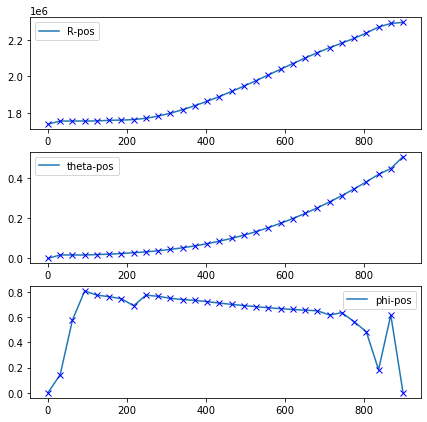

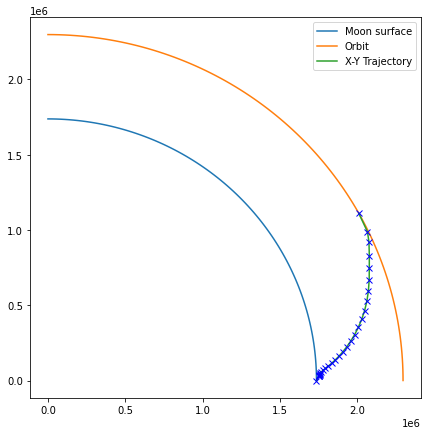

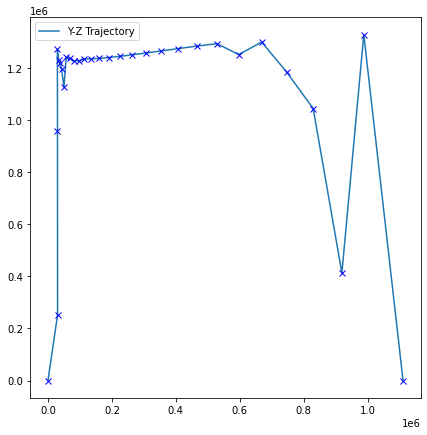

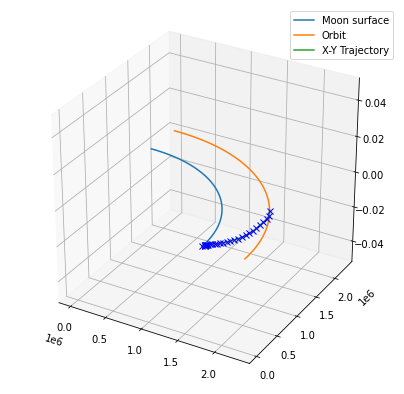

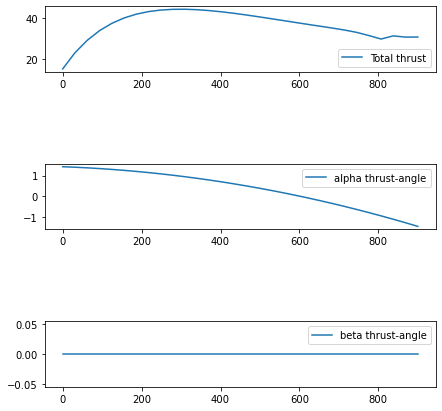

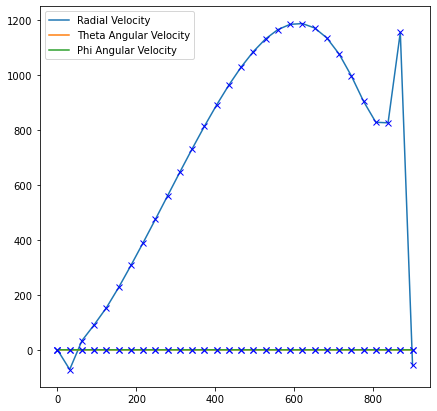

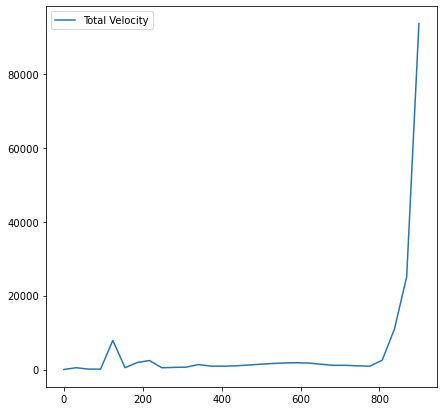

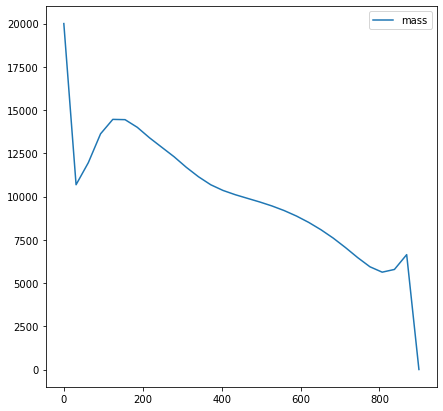

In [139]:
# retrieve internal nodes from results_all.json
#mO.open_folder()         # open run folder to see source and results files
import json
with open(mO.path+'//results.json') as f:
    results = json.load(f)
    
# PLANET AND ORBIT PARAMETRIZATION
theta = np.linspace(0, np.pi/2, 100)
x1_M = Rm*np.cos(theta)                   # moon parametrization
x2_M = Rm*np.sin(theta)
x1_O = (Rm+orb)*np.cos(theta)             # orbit parametrization
x2_O = (Rm+orb)*np.sin(theta)
x1_O2 = (Rm+orb2)*np.cos(theta)             # orbit 1 parametrization
x2_O2 = (Rm+orb2)*np.sin(theta)

# PLOT
print('')
print('Results')
print('x1O: ' + str(x1O))
print('x2O: ' + str(x2O))
print('x3O: ' + str(x3O))
print('x4O: ' + str(x4O))
print (x4O[-1])
print('x5O: ' + str(x5O))
print (x5O[-1])
print('x6O: ' + str(x6O))
print (x6O[-1])
#print('x7O: ' + str(x7O.value[-1]))
#print('Final Altitude: ' + str(altO.value[-1]))

    
# Position
plt.figure()
plt.subplot(311)
#plt.plot(tO_post,x4O_post,label='R-pos')
plt.plot(tO,x4O.value,label='R-pos')
plt.plot(results['time'],results['v4'],'bx')
plt.legend(loc='best')
plt.subplot(312)
#plt.plot(tO_post,x5O_post,label='theta-pos')
plt.plot(tO,x5O.value,label='theta-pos')
plt.plot(results['time'],results['v5'],'bx')
plt.legend(loc='best')
plt.subplot(313)
#plt.plot(tO_post,(x6O_post),label='phi-pos')
plt.plot(tO,x6O.value,label='phi-pos')
plt.plot(results['time'],results['v6'],'bx')
plt.legend(loc='best')

# Trajectory X-Y
plt.figure()
plt.plot(x1_M,x2_M,label='Moon surface')
plt.plot(x1_O,x2_O,label='Orbit')
#plt.plot(x4O_post*np.cos(x5O_post),x4O_post*np.sin(x5O_post),label='X-Y Trajectory')
plt.plot(x4O.value*np.cos(x5O.value),x4O.value*np.sin(x5O.value),label='X-Y Trajectory')
plt.plot(results['v4']*np.cos(results['v5']),results['v4']*np.sin(results['v5']),'bx')
plt.legend(loc='best')

# Trajectory Y-Z
plt.figure()
plt.plot(x4O.value*np.sin(x5O.value),x4O.value*np.sin(x6O.value),label='Y-Z Trajectory')
plt.plot(results['v4']*np.sin(results['v5']),results['v4']*np.sin(results['v6']),'bx')
plt.legend(loc='best')

# # Trajectory 3D
fig3D = plt.figure()
ax = fig3D.add_subplot(111, projection='3d')
plt.plot(x1_M,x2_M,label='Moon surface')
plt.plot(x1_O,x2_O,label='Orbit')
#plt.plot(x4O_post*np.cos(x5O_post),x4O_post*np.sin(x5O_post),label='X-Y Trajectory')
plt.plot(x4O.value*np.cos(x5O.value),x4O.value*np.sin(x5O.value),label='X-Y Trajectory')
plt.plot(results['v4']*np.cos(results['v5']),results['v4']*np.sin(results['v5']),'bx')
plt.legend(loc='best')

# Thrust
plt.figure()
plt.subplot(511)
#plt.plot(tO_post,u1O_post,label='Total thrust')
plt.plot(tO,u1O.value,label='Total thrust')
plt.legend(loc='best')
#plt.subplot(512)
#plt.plot(tO,u1O_val,label='Changing thrust')
#plt.legend(loc='best')
plt.subplot(513)
#plt.plot(tO_post,u2O_post,label='alpha thrust-angle')
plt.plot(tO,u2O.value,label='alpha thrust-angle')
plt.legend(loc='best')
#plt.subplot(514)
#plt.plot(tO,u2O_val,label='Changing alpha')
#plt.legend(loc='best')
plt.subplot(515)
#plt.plot(tO_post,u3O_post,label='beta thrust-angle')
plt.plot(tO,u3O,label='beta thrust-angle')
plt.legend(loc='best')

# Speed (individual components)
plt.figure()
#plt.plot(tO_post,x1O_post,label='Radial Velocity')
plt.plot(tO,x1O.value,label='Radial Velocity')
plt.plot(results['time'],results['v1'],'bx')
#plt.plot(tO_post,x2O_post,label='Theta angular velocity')
plt.plot(tO,x2O.value,label='Theta Angular Velocity')
plt.plot(results['time'],results['v2'],'bx')
#plt.plot(tO_post,x3O_post,label='Phi angular velocity')
plt.plot(tO,x3O.value,label='Phi Angular Velocity')
plt.plot(results['time'],results['v3'],'bx')
plt.legend(loc='best')

x1O_array= np.array(x1O.value)
x2O_array= np.array(x2O.value)
x4O_array= np.array(x4O.value)
#Speed (individual components)
plt.figure()
#plt.plot(tO_post,x1O_post,label='Total Velocity')
plt.plot(tO,(x1O_array**2+(x2O_array*x4O_array)**2)**(1/2),label='Total Velocity')
#plt.plot(results['time'],(results['v1']**2+(results['v2']*results['v4'])**2)**(1/2),'bx')
plt.legend(loc='best')



# Altitude
#plt.figure()
#plt.plot(tO_post,altO_post,label='altitude')
#plt.plot(tO.value,altO.value,label='altitude')
#plt.legend(loc='best')

# Flight path angle
#plt.figure()
#plt.plot(tO,gammaO,label='FPA')
#plt.legend(loc='best')

# Opeed
#plt.figure()
#plt.plot(tO,speedO,label='speed')
#plt.legend(loc='best')

# Mass
plt.figure()
#plt.plot(tO_post,x7O_post,label='mass')
plt.plot(tO,x7O.value,label='mass')
plt.legend(loc='best')
